# Homework 5 - Part 2
## Deep Learning Technologies
### Shruti Badrinarayanan - 016768141

## Load the Data

We begin by downloading and importing the data as a PyTorch dataset using the `Fashion MNIST` helper class from `torchvision.datasets`.

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
                              train=True,
                              download=True,
                              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:01<00:00, 14093622.72it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 295013.12it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4901324.21it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15635247.64it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Note that we are are transforming the pixel values from the range `[0, 1]` to the range `[-1, 1]`. The reason for doing this will become clear when define the generator network. Let's look at a sample tensor from the data.

In [2]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

As expected, the pixel values range from -1 to 1. Let's define a helper to denormalize and view the images. This function will also be useful for viewing the generated images.

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


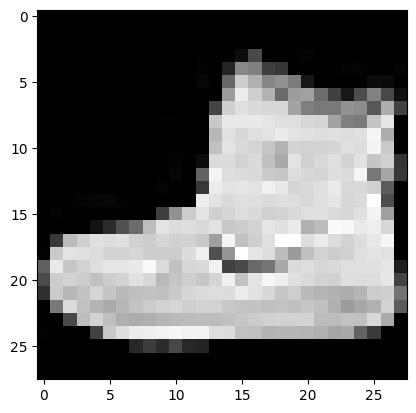

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Finally, let's create a dataloader to load the images in batches.

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([8, 5, 7, 5, 9, 6, 2, 9, 4, 9, 3, 7, 8, 6, 0, 8, 0, 8, 6, 6, 4, 7, 1, 3,
        5, 0, 2, 7, 1, 4, 8, 3, 9, 8, 9, 6, 4, 8, 3, 1, 6, 1, 6, 8, 9, 9, 2, 3,
        4, 3, 4, 8, 3, 6, 1, 2, 0, 3, 9, 2, 6, 2, 7, 5, 4, 7, 2, 5, 4, 9, 4, 2,
        6, 6, 9, 4, 0, 1, 3, 0, 2, 7, 9, 6, 6, 1, 5, 4, 3, 3, 0, 5, 6, 6, 3, 8,
        8, 2, 8, 7])


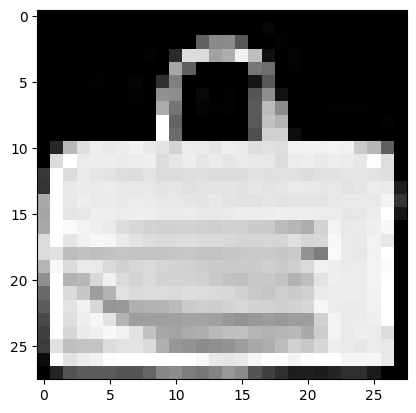

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cpu')

## Discriminator Network

In [9]:
image_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [11]:
D.to(device);

## Generator Network

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [14]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

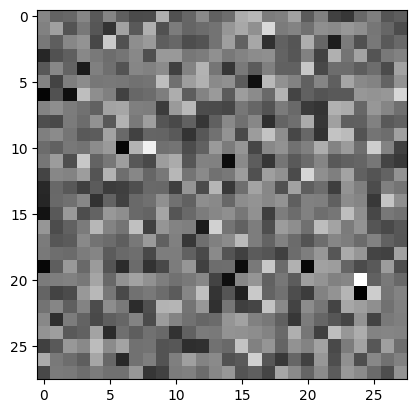

In [15]:
plt.imshow(gen_imgs[0], cmap='gray');

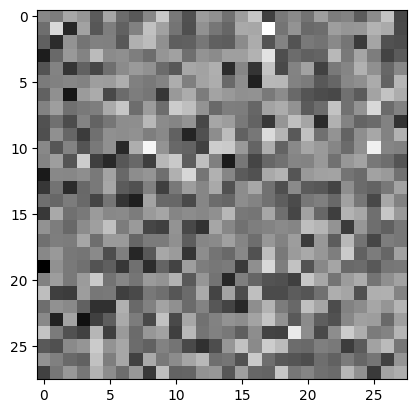

In [16]:
plt.imshow(gen_imgs[1], cmap='gray');

In [17]:
G.to(device);

## Discriminator Training

In [18]:
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

Let's define helper functions to reset gradients and  train the discriminator.

In [19]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(criterion, optimizer, discriminator_model, generator_model, images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = discriminator_model(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator_model(z)
    outputs = discriminator_model(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    optimizer.step()

    return d_loss, real_score, fake_score

## Generator Training

In [20]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [21]:
def train_generator(criterion, optimizer, discriminator_model, generator_model):
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(discriminator_model(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    optimizer.step()
    return g_loss, fake_images

## Training the Model

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model

In [22]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Let's save a batch of real images that we can use for visual comparision while looking at the generated images.

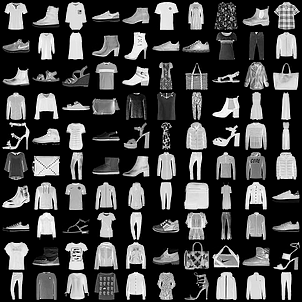

In [23]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


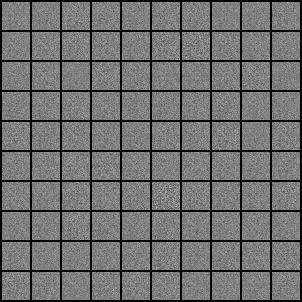

In [24]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator. The training might take a while if you're not using a GPU.

In [26]:
%%time

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(criterion, d_optimizer, D, G, images)
        g_loss, fake_images = train_generator(criterion, g_optimizer, D, G)

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/600], d_loss: 0.0220, g_loss: 0.8214, D(x): 0.98, D(G(z)): 0.14
Epoch [0/50], Step [400/600], d_loss: 0.0096, g_loss: 0.9367, D(x): 0.99, D(G(z)): 0.08
Epoch [0/50], Step [600/600], d_loss: 0.0152, g_loss: 0.9428, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.0028, g_loss: 0.9769, D(x): 0.99, D(G(z)): 0.02
Epoch [1/50], Step [400/600], d_loss: 0.0113, g_loss: 0.9880, D(x): 0.98, D(G(z)): 0.02
Epoch [1/50], Step [600/600], d_loss: 0.0019, g_loss: 0.9603, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 0.0039, g_loss: 0.9894, D(x): 0.98, D(G(z)): 0.00
Epoch [2/50], Step [400/600], d_loss: 0.0007, g_loss: 0.9755, D(x): 1.00, D(G(z)): 0.02
Epoch [2/50], Step [600/600], d_loss: 0.0024, g_loss: 0.9684, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 0.0043, g_loss: 0.9986, D(x): 0.99, D(G(z)): 0.00
Epoch [3/50], Step [400/600], d_loss

Now that we have trained the models, we can save checkpoints.

In [27]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Here's how the generated images look, after the 1st, 5th, 10th and 25th epochs of training.

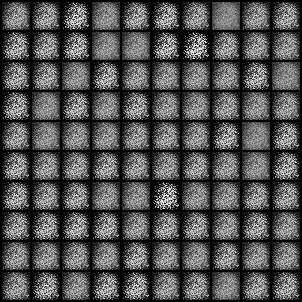

In [28]:
Image('./samples/fake_images-0001.png')

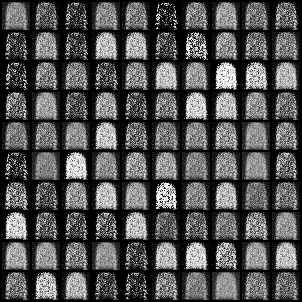

In [29]:
Image('./samples/fake_images-0005.png')

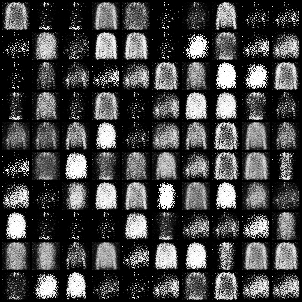

In [30]:
Image('./samples/fake_images-0010.png')

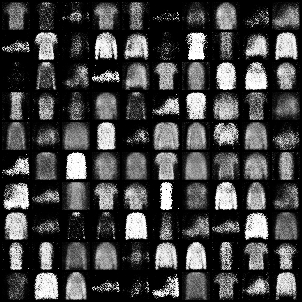

In [31]:
Image('./samples/fake_images-0025.png')

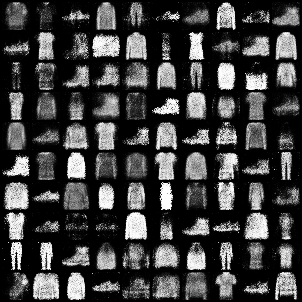

In [32]:
Image('./samples/fake_images-0050.png')

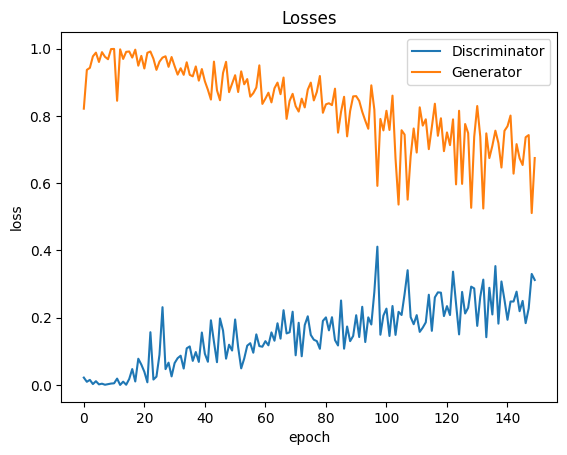

In [33]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

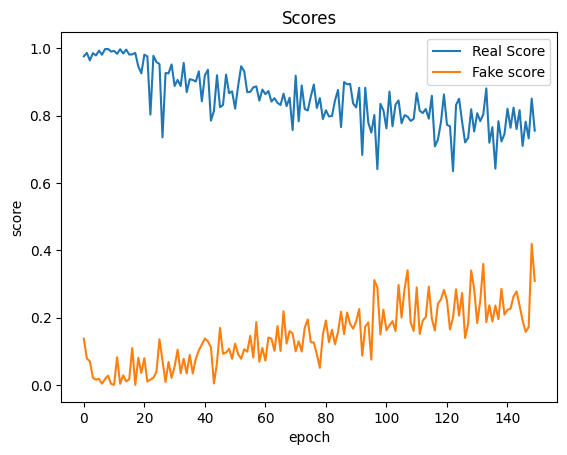

In [34]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

# Comparison
LS-GAN demonstrates faster convergence, higher stability, and potentially better sample quality compared to GAN. However, both models appear to be mostly effective in learning the underlying data distribution and generating realistic samples.